# Multi-Decoder Ruccurent Neural Network Auto-encoder (MDRA)

#### WE employed EUNN algorithm as RNN (See the following URL and put eunn.py in the same folder).
#### https://github.com/jingli9111/EUNN-tensorflow
####  https://github.com/iwyoo/LSTM-autoencoder/blob/master/LSTMAutoencoder.py
#### I used the above program as a referrence.(MIT Licence : Copyright (c) 2016 iwyoo)

## 1. Read data ( priodic functions)

In [1]:
import tensorflow as tf
import numpy as np
from eunn import EUNNCell
import generate_rnn_dataset as data_geterater
from scipy.special import digamma, gamma

/home/denso_miot/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data_max_length = 64
min_length=int(data_max_length*0.8)
freqs = [2,4,8]

In [3]:
import pickle

with open('train_x_tmp.pickle', 'rb') as f:
    train_x_tmp = pickle.load(f)
with open('test_x_tmp.pickle', 'rb') as f:
    test_x_tmp = pickle.load(f)

with open('train_seq_len_tmp.pickle', 'rb') as f:
    train_seq_len_tmp = pickle.load(f)
with open('test_seq_len_tmp.pickle', 'rb') as f:
    test_seq_len_tmp = pickle.load(f)  
    
with open('train_label.pickle', 'rb') as f:
    train_label = pickle.load(f)
with open('test_label.pickle', 'rb') as f:
    test_label = pickle.load(f) 

In [4]:
# Set input data dimension
time_series_dim = 1
train_x=np.reshape(train_x_tmp, [train_x_tmp.shape[0],train_x_tmp.shape[1],1])
test_x=np.reshape(test_x_tmp, [test_x_tmp.shape[0],test_x_tmp.shape[1],1])
print("Data size:",train_x.shape,test_x.shape)

Data size: (4500, 64, 1) (1500, 64, 1)


## 2. Definition of Multi-decoder RNN Autoencoder class(with EUNN)
#### The following code was used as a reference.
#### https://github.com/iwyoo/LSTM-autoencoder

In [5]:
"""
Args:
  hidden_num : number of hidden elements of each LSTM unit.
  inputs : a list of input tensors with size (batch_num x elem_num)
  optimizer : optimizer for rnn (the default option is`tf.train.AdamOptimizer`)
  reverse : Option to decode in reverse order.
  capacity: Parameter for EUNN
  fftflag: Parameter for EUNN (fft version or not)
  cpxflg : Parameter for EUNN (complex number or real number)
"""        
class MultiDecRNNAutoencoder(object):
    
    def __init__(
        self,
        hidden_num,
        inputs,
        seq_len,
        K,
        rnk,
        optimizer=None,
        reverse=False,
        capacity=4,
        fftflag=False,
        cpxflg = True
        ):

        if cpxflg:
            self.dataType = tf.complex64
        else:
            self.dataType = tf.float32 

        self.batch_num = inputs.get_shape().as_list()[0]
        self.step_num = inputs.get_shape().as_list()[1]
        self.elem_num = inputs.get_shape().as_list()[2]

        with tf.variable_scope('encoder'):            
            self._enc_cell = EUNNCell(hidden_num, capacity, fftflag, cpxflg)
            initial_state = self._enc_cell.zero_state(self.batch_num, dtype=self.dataType)
            initial_indecies = self._enc_cell.zero_state(self.batch_num, dtype=self.dataType)
            
            (self.z_codes, self.enc_state) = \
                tf.nn.dynamic_rnn(self._enc_cell, inputs, initial_state=initial_state, dtype=self.dataType,\
                sequence_length=seq_len)

        with tf.variable_scope('decoder',reuse=tf.AUTO_REUSE): #as vs:
            
            if cpxflg: 
                dec_weight_ = \
                    tf.Variable(tf.truncated_normal([2*hidden_num, self.elem_num], dtype=tf.float32), name='dec_weight')

            else:
                dec_weight_ = \
                    tf.Variable(tf.truncated_normal([hidden_num, self.elem_num], dtype=tf.float32), name='dec_weight')
            
            dec_weight_ = tf.tile(tf.expand_dims(dec_weight_, 0), [self.batch_num, 1, 1])
            dec_bias_ = tf.Variable(tf.constant(0.1, shape=[self.elem_num], dtype=tf.float32), name='dec_bias')
            self.ak = tf.Variable(tf.constant(1/K, shape=[K], dtype=tf.float32), name='cluster_weight')
            self.dec_inputs = tf.zeros(shape =[self.batch_num, self.step_num, self.elem_num], dtype=tf.float32)
            
            self.dec_outputs = []
            self.dec_stetes = []
            
            for k in range(K):
                with tf.variable_scope("RNNCell"+str(k)):
                    tmpCell = EUNNCell(hidden_num, capacity, fftflag, cpxflg)
                    
                (tmpOut, tmpState) = \
                    tf.nn.dynamic_rnn(tmpCell,self.dec_inputs, initial_state=self.enc_state,dtype=self.dataType,\
                    sequence_length=seq_len)
                self.dec_outputs.append(tmpOut)
                self.dec_stetes.append(tmpState)

            if reverse:
                tmp_outputs_ = self.dec_outputs[k][::-1]
            else:
                tmp_outputs_ = self.dec_outputs[k]
                
            lossSum = tf.zeros([self.batch_num], dtype=tf.float32)

            ClassLoss =[]
            weightClassLoss = []
            self.or_loss = []
            self.wg_loss =[]
            for k in range(K):                       
                if cpxflg:
                    if reverse:
                        tmp_outputs_ = self.dec_outputs[k][::-1]
                    else:
                        tmp_outputs_ = self.dec_outputs[k]

                    dec_outputs_real=tf.real(tmp_outputs_)
                    dec_outputs_imag=tf.imag(tmp_outputs_)
                    self.dec_output_=tf.concat([dec_outputs_real, dec_outputs_imag],2)                   
                    self.output_ = tf.matmul(self.dec_output_, dec_weight_) + dec_bias_
                                        
                else:
                    if reverse:
                        self.dec_outputs = self.dec_outputs[::-1]

                    self.dec_output_ = tf.transpose(tf.stack(self.dec_outputs), [1, 0, 2])
                    self.output_ = tf.matmul(self.dec_output_, dec_weight_) + dec_bias_
                    
                dataSub = tf.subtract(inputs,self.output_)
                dataSub_sqr =  tf.square(dataSub)
                dataSubSqrSum = tf.reduce_mean(dataSub_sqr,1)
                ClassLoss.append(dataSubSqrSum)
                dataSubSqrSumSq=tf.squeeze(dataSubSqrSum)
                loss_weight=tf.multiply(rnk[k],dataSubSqrSumSq)
                self.wg_loss.append(loss_weight)
                sumLossweight_batch = tf.reduce_mean(loss_weight)
                weightClassLoss.append(sumLossweight_batch)
                
            #for debug
            self.wg_loss=tf.convert_to_tensor(self.wg_loss, dtype=tf.float32)
                
            weightClassLoss = tf.convert_to_tensor(weightClassLoss, dtype=tf.float32)
            self.loss = tf.reduce_mean(weightClassLoss) 
            self.classLoss=tf.squeeze(tf.convert_to_tensor(ClassLoss, dtype=tf.float32))
            print("weightClassLoss",weightClassLoss,"self.loss",self.loss,"classLoss",self.classLoss)

        if optimizer is None:
            self.train = tf.train.GradientDescentOptimizer(0.002).minimize(self.loss)
        else:
            self.train = optimizer.minimize(self.loss)

## 3. Create MDRA instance

In [6]:
tf.reset_default_graph()
# Constants
batch_num = 256
hidden_num = 16 
step_num = data_max_length 
elem_num = 1
iteration = 500
dataNum = train_x.shape[0]
Capacity = 4
fftFlag = "False"
cpxFlag = "True"
K = 7

p_input = tf.placeholder(tf.float32, [batch_num, step_num, elem_num])
seqLen = tf.placeholder(tf.int32, [batch_num])
rnk = tf.placeholder(tf.float32, [K,batch_num])
ak = np.zeros(K) 
ae = MultiDecRNNAutoencoder(hidden_num, p_input,seqLen,K,rnk,reverse=False, capacity=Capacity, fftflag=fftFlag, cpxflg=cpxFlag)

weightClassLoss Tensor("decoder/packed_1:0", shape=(7,), dtype=float32) self.loss Tensor("decoder/Mean_14:0", shape=(), dtype=float32) classLoss Tensor("decoder/Squeeze_7:0", shape=(7, 256), dtype=float32)


## 4. Excute the processing

In [7]:
import copy
np.random.seed()
n_batch = dataNum // batch_num

# Parameter setting
final_data_order = []
final_rnk = []
final_all_label = []
min_loss =1000.0
min_epoc=0
# For VB part parameters,thetaK,nu0,lambdaK,etc.
theta0=0.07
nu0=1.0
lambda0=5.0
thetaK=np.full(K, 0.0)
aveAlphaK=np.full(K, 0.0)
lambdaK=np.full(K, 0.0)
Nk=np.full(K, batch_num/K)
rkn_tmp=np.full((K,batch_num), 1/K) # Remark: rnk is described as $y_{nk}$ in the paper
log_rhoKN=np.full((K,batch_num), np.log(1/K))
rhoKN=np.full((K,batch_num), 1.0)
rKN=np.full((K,batch_num), 1/K)
beta_rnk_tmp=np.zeros(rkn_tmp.shape)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #------ VB part finction------------------------------------------------
    def rnk_culc(classloss,batch_num,K,thetaK,nu_,lambda_,batch_seq_len):#classloss[K,N]
        for k in range(K):
            for n in range(batch_num):
                log_rhoKN[k,n] = digamma(thetaK[k])-digamma(np.sum(thetaK, axis=0))-classloss[k,n]*nu_*(1.0/lambda_)\
                + (elem_num*(batch_seq_len[n])/2.0)*(digamma(nu_)-np.log(lambda_)-np.log(np.pi))

        max_log_rho=np.max(log_rhoKN,axis=0) # N
        max_log_rho_mat=np.tile(max_log_rho,(K,1)) 
        rhoKN=np.exp(log_rhoKN-max_log_rho_mat) #[K,N]-[k,n]
        norm_rhoN=np.sum(rhoKN,axis=0)
        for n in range(batch_num):
            rKN[:,n]=rhoKN[:,n]/norm_rhoN[n]                
                            
        return rKN
    #-----------------------------------------------------------------------
    final_flag = 0
    for ep in range(iteration):
        min_rnk_tmp = []
        min_all_label=[]
        min_hidden_tmp = []
        train_loss_sum = 0
        perm = np.random.permutation(dataNum) 

        for bt in range(n_batch):    
            start = bt * batch_num
            end = start + batch_num
            batch_input =  train_x[perm[start:end],:,:]
            batch_seq_len = train_seq_len_tmp[perm[start: end]]
            batch_label=train_label[perm[start: end]]

            # ========== >>>> VB step
            (classloss,wg_loss) = sess.run([ae.classLoss,ae.wg_loss], {p_input: batch_input,seqLen:batch_seq_len,rnk:rkn_tmp})
            #---VB-M step
            Nk=np.sum(rkn_tmp,axis=1)
            thetaK=theta0+Nk
            tmp_rkn_classloss = classloss*rkn_tmp
            lambda_ = lambda0+np.sum(tmp_rkn_classloss)
            nu_=nu0+1.0/2.0*np.sum(batch_seq_len)*elem_num
            #---VB-E step
            rkn_tmp = rnk_culc(classloss,batch_num,K,thetaK,nu_,lambda_,batch_seq_len)

            for k in range(len(lambdaK)):
                beta_rnk_tmp[k,:]=rkn_tmp[k,:]*(nu_/lambda_)

            # =========== >>>> RNN (MLE) step
            rkn_learn = rkn_tmp*K  
            (train_loss,_,hidden) =sess.run([ae.loss,ae.train,ae.enc_state], {p_input: batch_input,seqLen:batch_seq_len,rnk:rkn_learn})
            train_loss_sum += train_loss

            min_hidden_tmp.append(hidden)
            rkn_for_min=copy.deepcopy(rkn_tmp)
            min_rnk_tmp.append(rkn_for_min)
            min_all_label.append(batch_label)
            
            # Save the final results (these are not used the following process.(use only minimum) )
            if ep == iteration-1 or final_flag==1:
                rkn=copy.deepcopy(rkn_tmp)
                final_data_order.append(batch_input)
                final_rnk.append(rkn)
                final_all_label.append(batch_label)
   
        diggmasumTheta = digamma(np.sum(thetaK, axis=0))
        aveAlphaK=digamma(thetaK)-diggmasumTheta
        if ep % 100 ==0:
            print("average alpha_K",np.exp(aveAlphaK),"beta",(nu_/lambda_))
        
        train_loss_sum /= n_batch
        if ep % 100 ==0:
            print("epoch:",ep, "-->","train loss/min_loss:", train_loss_sum,min_loss,"min_epoc",min_epoc)
        
        if min_loss > train_loss_sum:
            min_rnk = min_rnk_tmp
            min_hidden=min_hidden_tmp
            min_loss = train_loss_sum
            min_label=min_all_label
            min_epoc = ep
        if ep % 100 ==0:
            print("---------------------------------")  
        if final_flag == 1:
            break            
        if train_loss_sum < 0.01:
            final_flag = 1
            print("Loss is less than threshold.",final_flag)
        if ep == (iteration-1):
            print("Process has done without Loss < threshold.")



average alpha_K [0.00131143 0.04053582 0.01503656 0.55249447 0.14075465 0.04858173
 0.18998871] beta 96.37330038891649
epoch: 0 --> train loss/min_loss: 0.251751654288348 1000.0 min_epoc 0
---------------------------------
average alpha_K [1.52928562e-09 1.52928545e-09 1.52929032e-09 3.77241798e-01
 2.63955543e-01 1.52929722e-09 3.53807722e-01] beta 86.59225141174922
epoch: 100 --> train loss/min_loss: 0.06349234524018624 0.05746098607778549 min_epoc 78
---------------------------------
average alpha_K [1.52928478e-09 1.52928569e-09 1.52928475e-09 3.65523666e-01
 2.63957793e-01 1.52930496e-09 3.65523600e-01] beta 80.55486387803855
epoch: 200 --> train loss/min_loss: 0.05435482631711399 0.041300263474969304 min_epoc 193
---------------------------------
average alpha_K [1.52928473e-09 1.52928475e-09 1.52928471e-09 3.42085325e-01
 2.95208782e-01 1.52928473e-09 3.57710854e-01] beta 81.2901265013965
epoch: 300 --> train loss/min_loss: 0.03461535581771065 0.03168654781492317 min_epoc 206
--

## 5. Display output using MDS

In [8]:
# --- 1.change data type
min_rnk=np.array(min_rnk)
min_label=np.array(min_label)
min_hidden=np.array(min_hidden)

# --- 2.create data set and label for visualization
min_rnk_array = []
min_label_array = []
min_hidden_array = []

for bt_loop in range(min_label.shape[0]):
    for bt in range(min_label.shape[1]):
        min_rnk_array.append(min_rnk[bt_loop,:,bt])
        min_label_array.append(min_label[bt_loop,bt])
        min_hidden_array.append(min_hidden[bt_loop,bt,:])

# --- 3.change data type to array        
min_hidden_array = np.array(min_hidden_array)
min_rnk_array = np.array(min_rnk_array)
min_label_array=np.array(min_label_array)
real_hidden = np.real(min_hidden_array)
imag_hidden = np.imag(min_hidden_array) 
hidden_expression = np.concatenate([real_hidden, imag_hidden], axis=1)

In [9]:
# ---- create data label
red=[]
green=[]
blue=[]
for d in range(min_label_array.shape[0]):
    if min_label_array[d] == freqs[0]:
        red.append(d)
    elif min_label_array[d] == freqs[1]:
        blue.append(d)
    elif min_label_array[d] == freqs[2]:
        green.append(d)
    elif min_label_array[d] == freqs[3]:
        black.append(d)
    elif min_label_array[d] == freqs[4]:
        yellow.append(d)        


In [10]:
# --- dimension reduction by MDS
from sklearn import manifold
from time import time
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100)
X_mds_min = clf.fit_transform(min_rnk_array)
X_mds_min_hidden = clf.fit_transform(hidden_expression.astype(np.float64))

## 6. Feature extraction result : allocation weight $r_{nk}$

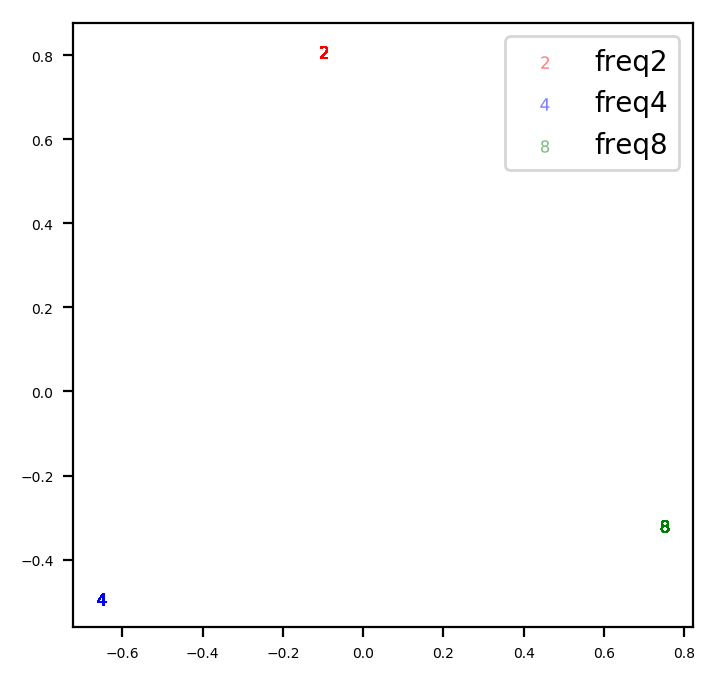

In [11]:
import matplotlib.pyplot as plt
xb=X_mds_min[blue,0] 
yb=X_mds_min[blue,1]

xr=X_mds_min[red,0] 
yr=X_mds_min[red,1]

xg=X_mds_min[green,0] 
yg=X_mds_min[green,1]

fig = plt.figure(figsize=(4,4),dpi=200)
ax = fig.add_subplot(1,1,1)

transp = 0.5
m_size = 20
ax.scatter(xr, yr, color = "red", s=m_size,alpha=transp,marker='$2$',linewidths = '0.01',label="freq" + str(freqs[0]))
ax.scatter(xb, yb, color = "blue", s=m_size,alpha=transp,marker='$4$',linewidths = '0.01',label="freq" + str(freqs[1]))
ax.scatter(xg, yg, color = "green", s=m_size,alpha=transp,marker='$8$',linewidths = '0.01',label="freq" + str(freqs[2]))

plt.tick_params(labelsize=5)
plt.legend()
plt.show()

## 7. Feature extraction result : hidden state ${h}$

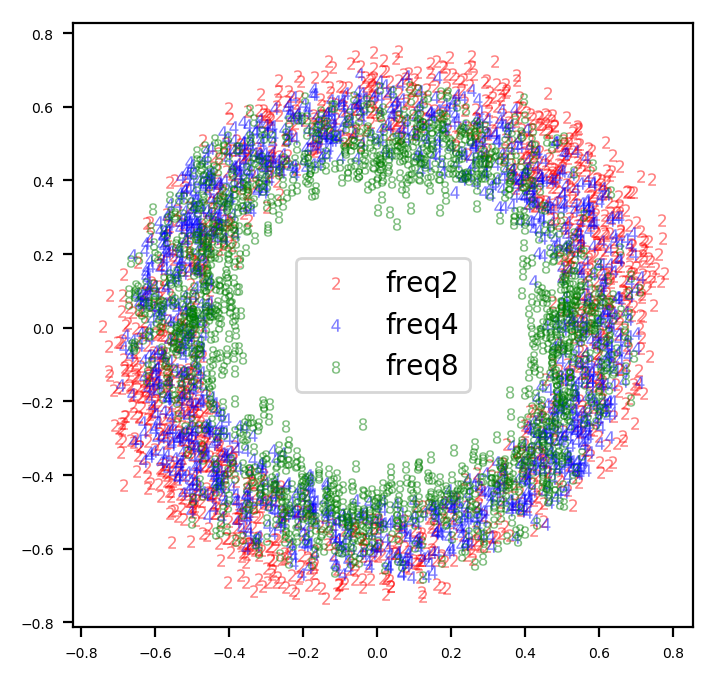

In [12]:
xb=X_mds_min_hidden[blue,0] 
yb=X_mds_min_hidden[blue,1]

xr=X_mds_min_hidden[red,0] 
yr=X_mds_min_hidden[red,1]

xg=X_mds_min_hidden[green,0] 
yg=X_mds_min_hidden[green,1]

fig = plt.figure(figsize=(4,4),dpi=200)
ax = fig.add_subplot(1,1,1)

ax.scatter(xr, yr, color = "red", s=m_size,alpha=transp,marker='$2$',linewidths = '0.01',label="freq" + str(freqs[0]))
ax.scatter(xb, yb, color = "blue", s=m_size,alpha=transp,marker='$4$',linewidths = '0.01',label="freq" + str(freqs[1]))
ax.scatter(xg, yg, color = "green", s=m_size,alpha=transp,marker='$8$',linewidths = '0.01',label="freq" + str(freqs[2]))

plt.tick_params(labelsize=5)
plt.legend()
plt.show()